# Reccomendations Tool
This tool is inteded to provide patrons of the Orem Public Library with book recomendations.

We begin with importing our python libraries which will be used throughout the program.

In [1]:
import string
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import Series
from ast import literal_eval
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

We are loading each dataset into their respective dataframes.

In [2]:
# Storing data in dataframes
ratings_df = read_csv('https://raw.githubusercontent.com/malcolmosh/goodbooks-10k-extended/master/ratings.csv')
books_df = read_csv('https://raw.githubusercontent.com/malcolmosh/goodbooks-10k/master/books_enriched.csv',
                       index_col=[0], converters={"genres": literal_eval})

We are dropping excess columns from the books dataframe. This trims it down to only the essential columns. (author, average rating, book id, description, generes, pages, and title.)

In [3]:
# Dropping excess columns from books_df.
books_df = books_df.drop(columns=["index", "best_book_id", "books_count", "goodreads_book_id", "isbn",
                                  "isbn13", "language_code", "original_title", "ratings_1", "ratings_2",
                                  "ratings_3", "ratings_4", "ratings_5", "ratings_count", "work_id",
                                  "work_ratings_count", "work_text_reviews_count", "authors_2", "image_url",
                                  "small_image_url", "publishDate", "original_publication_year", "authors_2"])

We are ensuring we only have users who have reviewed more than 100 books. This narrows our dataset to well read users, and ensures we don't over tax the system resources with less optimal user reviews. We also add a 'total reviews' column which contains the total number of reviews completed by each user. 

In [4]:
# Dropping users with less than 100 reviews
well_read = ratings_df['user_id'].value_counts() > 100
well_read_list = well_read[well_read].index
ratings_df = ratings_df[ratings_df['user_id'].isin(well_read_list)]
# Add a column to determine well read users (users with lots of reviews).
ratings_df['total_reviews'] = ratings_df.groupby('user_id')['user_id'].transform('count')

This variable will be referenced throughout the program. It will contain the single dataframe which matches the partons searched book.

In [5]:
user_book = []

The following two functions deal with the user input. user_input takes the partorns searched book, and pushes it through validate_input. validate_input checks to see if the searched term is in the books database. It then looks to see if the searched term exists in more than one title. If it does, it provides a numbered list to the user. Users are required to enter the number beside their desired book. If the title does not exist in the database, the patron is prompted to try another search.

In [6]:
def user_input():
    global user_book
    print("\n")
    user_search = input("Enter your book: ")
    user_book = books_df.loc[books_df['title'].str.contains(user_search, case=False)]
    correct = validate_input(user_book, user_search)
    return correct


def validate_input(book, search):
    global user_book
    print("- - - - - - - - - - - - - - - - - -")
    if len(book) < 1:
        print("We don't have ", search ," in our system. Please try another book.")
        return False
    if len(book) > 1:
        print("Your search returned multiple results. Please enter the full title of your desired book.")
        print("Results for your search are below.")
        for i in range(0, len(book)):
            print(i + 1, " ", book['title'].values[i])
        new_search = input("Enter the number beside your desired book: ")
        print("\n")
        if new_search.isnumeric():
            if int(new_search) < 1 or int(new_search) > len(book):
                print("Invalid entry.")
                print("\n")
                return False
            else:
                user_book = books_df.loc[books_df.index == book.index[int(new_search) - 1]]             
                return True

This calls the above functions. The input is not valid until validate retuns True. If validate never returns True, the cycle of verification of user input will continue forever. Otherwise, it will exit the while loop after assigning a value to user_book.

In [7]:
print("Welcome to the book reccomendation tool.\n")

validate = False
validate = user_input()  
while validate == False:
    validate = user_input() 

Welcome to the book reccomendation tool.



Enter your book: the kite runner
- - - - - - - - - - - - - - - - - -


The top_ratings function compiles a new dataframe called relevant_books_df. This dataframe contains any book with a five star rating from useres who rated the searched book with five stars. It is assumed, a five star rating completed by a single user could translate into similar results. Meaning the patron searching said book might also rate these other books with five star ratings.

At lien 10, we take 25 users with the most reviews who have also reviewed the searched book. In seaching users with high review counts, we get a larger list of books to compare later in the program. This list is compiled in lines 15-18.

Lines 21 and 22 are to create the relevant_books_df which will be returned to program. 

line 29 to the end are run if no users have reviewed the book being searched. 

In [8]:
def top_ratings():
    global user_book
    # Creates a list of books related to searched book with a rating of 5.
    related_uid_list = ratings_df.loc[ratings_df['book_id'] == user_book['book_id'].values[0]].loc[ratings_df['rating'] == 5]

    # If reviews found
    if len(related_uid_list) != 0:
        complete_rec_list = []

        # Take top 25 best read users from list
        top_related_uid = related_uid_list.sort_values('total_reviews', ascending=False).drop_duplicates(
            subset=['user_id']).head(25)

        # For each user_id of 25 best read users, search for all book_id with rating = 5
        for i in related_uid_list.user_id:
            # 4 Create list of book_id, rating = 5 do not dedup.
            rec_list = five_by_user(i)
            complete_rec_list.append(rec_list)

        # Create list from books_df found in book_ids from rec_books.
        relevant_books_df: object = books_df[books_df['book_id'].isin(shorten_books_df(complete_rec_list))]
        relevant_books_df = combine_for_analysis(relevant_books_df)
        
        return relevant_books_df
    
    # If no reviews found
    else:
        # If no users have reviwed the book, do a similarities comparison on entire database.
        relevant_books_df = combine_for_analysis(books_df)

        return relevant_books_df

This function is called during the top_ratings function at line 17. We are given every user id who rated the searched book with five stars. That list is then used to generate another list which contains every book those users rated with five stars. This returns a list of books rated with five stars by each of the given users. Books may appear multiple times as multiple users may have rated the same book with five stars.

In [9]:
def five_by_user(user_id):
    # For each user_id search for all book_id with rating = 5
    user_rec = ratings_df.loc[ratings_df['user_id'] == user_id].loc[ratings_df['rating'] == 5]
    return user_rec.book_id

This function is called during the top_ratings function at line 21. We take the recommended_list which contains every five star rating completed by any user who raited the patrons searched book with five stars, and count the number of times any book occurs. We then order this list from most commonly occuring to least commonly occuring. Once sorted, the list is returned to the top_ratings function.

In [10]:
def shorten_books_df(recommended_list):
    rec_books = []
    # Check for top re-occurring book_id: complete_rec_list {book_id : occurrence_count}
    complete_rec_list = list(Counter(x for sublist in recommended_list for x in sublist).items())
    # Orders the dictionary. Lowest to highest occurrence.
    sorted_complete_recs = sorted(complete_rec_list, key=lambda x: int(x[1]))
    # Top 55 results. Last result is the searched book itself.
    relevant_books = sorted_complete_recs[len(sorted_complete_recs) - 56:]
    # Drop re-occurrence count leaving ordered book_id.
    for i in relevant_books:
        # rec_books is a list of book_id from lowest to highest read
        rec_books.append(i[0])
    return rec_books

This function is called during the top_ratings function at line 22. It takes notable columns and combines into a new column named similarities_comp. This column will be used for a similarities comparison later in the program.

In [11]:
def combine_for_analysis(df):
    # Prep table for similarity comparison.
    # Combine relevant columns for similarity evaluation.
    df = df.copy()
    df['similarities_comp'] = df['authors'] + df['title'] + \
                              df['genres'].astype(str) + df['description']
    return df

The descriptive_images function is called during the top_ratings function at lines 24 and 33. These visualizations depict the average rating of each title in from our list of recomended books list, and the average rating in relation to the number of pages in a book from our recomended books list. 

The word_cloud function is called later during the output function. It takes a string, the description string in this instance, and splits it by word. Punctuations and stop words are removed. The image settings are defined and the word cloud is generated.

In [12]:
def descriptive_images(df):
    # Average ratings per title.
    df.plot(kind='bar', x='title', y='average_rating', xlim=(0,1), figsize = (20,5), title="Average Ratings by Title");

    # Average ratings per page count.
    df.plot(kind='scatter', x='pages', y='average_rating', figsize = (5,5), title="Average Ratings by Page Count");

    
def word_cloud(analyze_text, title):
    common_words = ''
    string_value = str(analyze_text)
    tokenize = string_value.split()

    common_words += " ".join(tokenize) + " "
    cloud = WordCloud(width=800, height=800, background_color='white',
                      stopwords=stopwords.words('english'), min_font_size=10).generate(common_words)
    plt.figure(figsize=(10, 10))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()  

The comparison function takes the relevant_books_df generated in the top_ratings function and adds a new column to with a unique id associated with each book in the dataframe. This also provides a range to be used in the score_series on line 14. 

Line 7 identifies the row wich contains our searched book.

Lines 10 - 12 runs the CountVectorizer function found in sklearn library which was imported earlier which is then run through the cosine_similarity function also found within the sklearn library. The result a list of similarity scores.

Lines 15 - 17 create a pared list of uid and similarities score. It then sorts the list according to similarity score. Items with the highest similarity are at the top while items with the lowest similarity score are at the bottom.

In [13]:
def comparison(df):
    # Creates a unique id and sets the range.
    total_index = []
    for i in range(0, len(df)):
        total_index.append(i)
    df['uid'] = total_index
    searched_index = df.loc[df['book_id'] == user_book['book_id'].values[0]]

    # Generate count matrix.
    count_matrix = CountVectorizer().fit_transform(df['similarities_comp'].fillna(' '))
    # Cosine sim matrix from cm.
    cosine_sim = cosine_similarity(count_matrix)
    # Creates a numbered paired list of id and similarity rating.
    score_series = list(enumerate(cosine_sim[searched_index.uid.values[0]]))
    # Order score series starting with closest matching.
    sorted_scores = sorted(score_series, key=lambda x: x[1], reverse=True)[:]
    return sorted_scores

The output function takes two perameters: dataframe and the score_series. There were issues extrapolating single values, so definitions were created to provide these values.

For every item in score_series, pull the values of the title, author, and average rating. We use these to populate our recomendations display to the patron. We also identify the searched book and the first recommendation to generate word clouds for the user to compare for themselves. 

We also create a list of likeness scores, average rating, and title. This allows us to create the scatter diagram which corilates that data. Books at the top left most corner of the display are optimal for the patrons next read.

In [14]:
def output(df, scores):
    descriptive_images(df)
    count = 1
    likeness = []
    scatter_data = []
    print("\n\n- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -\n")
    print("\t\t\tYour Results\n- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
    
    
    def book_title(uid):
        book_row = df[df['uid'] == uid]
        return book_row.title.values[0]

    def book_authors(uid):
        book_row = df[df['uid'] == uid]
        return book_row.authors.values[0].strip("'[]")

    def book_average_rating(uid):
        book_row = df[df['uid'] == uid]
        return book_row.average_rating.values[0]

    def top_book(uid):
        book_row = df[df['uid'] == uid]
        return book_row
    
    for i in list(zip(*scores))[0]:
        title = book_title(i)
        authors = book_authors(i)
        average = book_average_rating(i)
        # 9 Return top 50 recommended books
        if count <= 55:
            if count == 1:
                first_book = top_book(i)
            if count == 2:
                first_rec = top_book(i)
            if count > 1:
                if count - 1 <= 10:
                    print(count - 1, " ", title, " by ", authors.replace("'", ""))                    
                likeness.append("{:.0%}".format(list(zip(*scores))[1][count - 1]))
                scatter_data.append(["{:.0%}".format(list(zip(*scores))[1][count - 1]).strip('%'), average, title])
            count = count + 1
    df['likeness'] = Series(likeness)
    df = df.fillna(0)

    # Word Cloud for searched book.
    word_cloud(first_book['description'].values[0], first_book['title'].values[0])

    # Word Cloud for top recommended book.
    word_cloud(first_rec['description'].values[0], first_rec['title'].values[0])

    # Displays the corilation between likeness and average_rating with the title as the lable
    test1 = list(zip(*scatter_data))
    data1 = plt.scatter(test1[0][0], test1[1][0], marker='d', label=test1[2][0])
    data1 = plt.scatter(test1[0][1], test1[1][1], marker='d', label=test1[2][1])
    data1 = plt.scatter(test1[0][2], test1[1][2], marker='d', label=test1[2][2])
    data1 = plt.scatter(test1[0][3], test1[1][3], marker='d', label=test1[2][3])
    data1 = plt.scatter(test1[0][4], test1[1][4], marker='d', label=test1[2][4])
    data1 = plt.scatter(test1[0][5], test1[1][5], marker='d', label=test1[2][5])
    data1 = plt.scatter(test1[0][6], test1[1][6], marker='d', label=test1[2][6])
    data1 = plt.scatter(test1[0][7], test1[1][7], marker='d', label=test1[2][7])
    data1 = plt.scatter(test1[0][8], test1[1][8], marker='d', label=test1[2][8])
    data1 = plt.scatter(test1[0][9], test1[1][9], marker='d', label=test1[2][9])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), 
           ncol=2)
    plt.xlabel("Similaritis %")
    plt.ylabel("Average Rating")
    plt.title("Recommendation Chart")
    plt.show()



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

			Your Results
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
1   The Pillars of the Earth (The Kingsbridge Series, #1)  by  Ken Follett
2   A Thousand Splendid Suns  by  Khaled Hosseini
3   A Game of Thrones (A Song of Ice and Fire, #1)  by  George R.R. Martin
4   The Great Gatsby  by  F. Scott Fitzgerald
5   Lord of the Flies  by  William Golding
6   Harry Potter and the Order of the Phoenix (Harry Potter, #5)  by  J.K. Rowling, Mary GrandPré
7   Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)  by  J.K. Rowling, Mary GrandPré, Rufus Beck
8   The Catcher in the Rye  by  J.D. Salinger
9   The Red Tent  by  Anita Diamant
10   Harry Potter and the Half-Blood Prince (Harry Potter, #6)  by  J.K. Rowling, Mary GrandPré


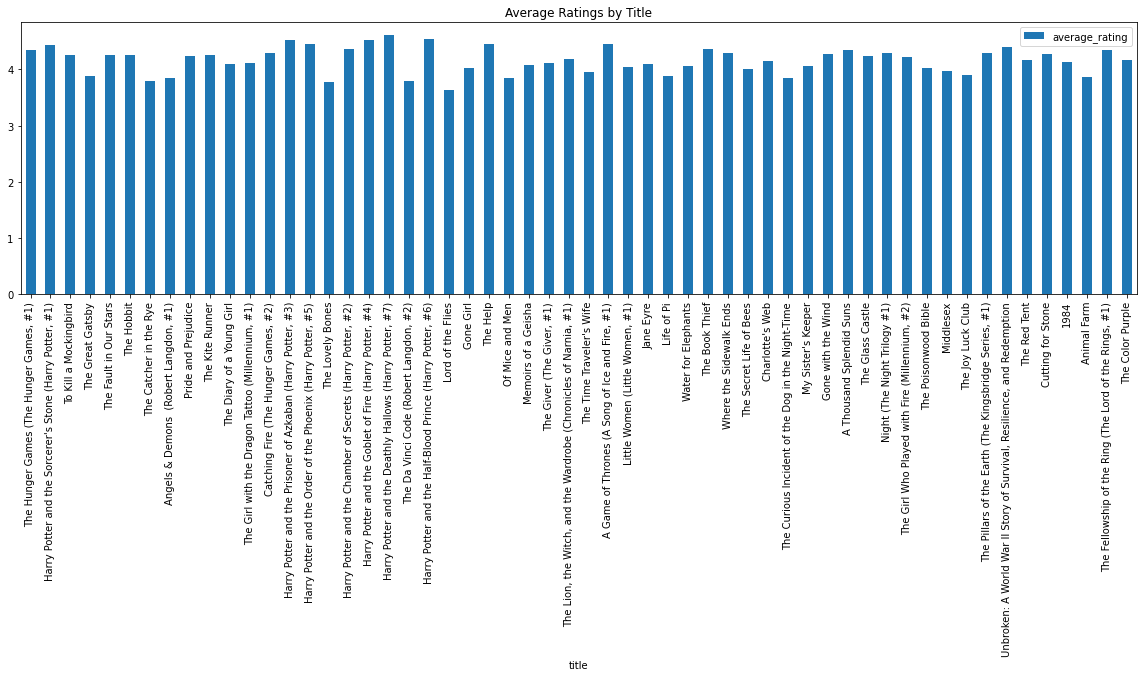

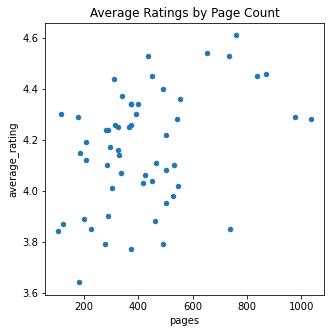

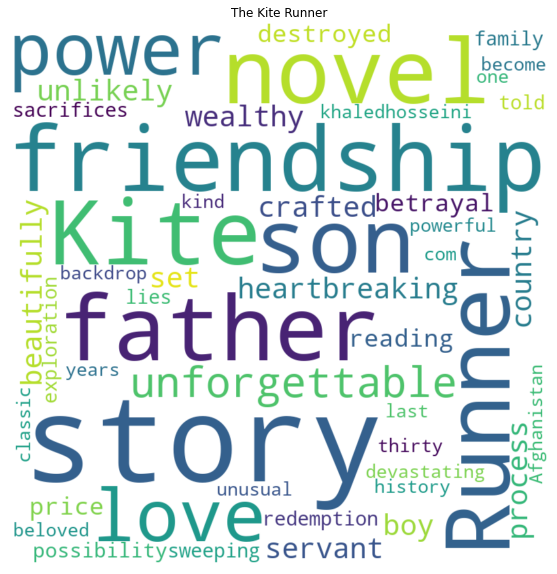

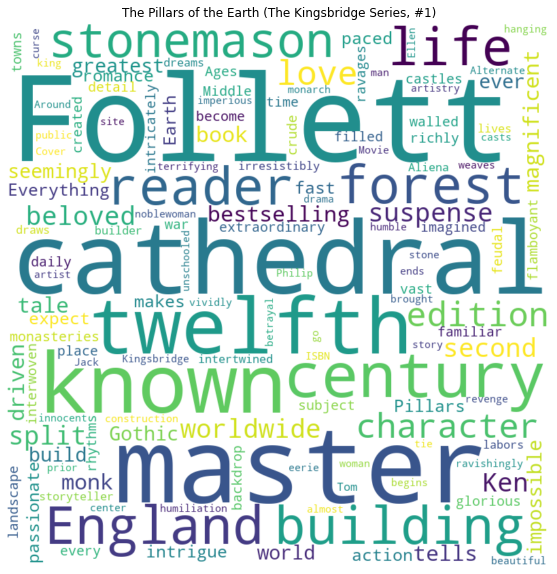

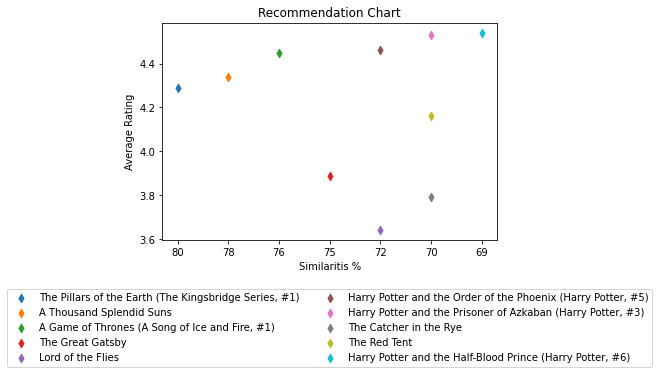

In [15]:
top_ratings()

related_books_df = top_ratings()

output(related_books_df, comparison(related_books_df))